# Spatial Cross-Correlation of GMCs and HII Regions in PHANGS (ALMA+MUSE)

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import astropy.io.fits as fits
import astropy.io.ascii as ascii
from astropy import wcs
from astropy.coordinates import SkyCoord
from photutils import SkyCircularAperture
from photutils import aperture_photometry
import astropy.units as u
from reproject import reproject_interp
from scipy.interpolate import NearestNDInterpolator
import time

np.random.seed(666)

## Name of galaxy

In [54]:
#galaxy='IC5332'
galaxy='NGC0628'
#galaxy='NGC1087'
#galaxy='NGC1365' 
#galaxy='NGC1512'
#galaxy='NGC1672'
#galaxy='NGC2835'
#galaxy='NGC3351'
#galaxy='NGC3627'
#galaxy='NGC5068'


## Routine to get basic parameters of a galaxy

In [55]:
# Get basic positional parameters for a galaxy
def getparams(name):
    sample=fits.open('./catalogs/phangs_sample_table_v1p4.fits')
    names=sample[1].data['NAME']
    sel=sample[1].data['NAME']==name
    data=sample[1].data[sel]
    
    ra0=data['ORIENT_RA'][0]
    dec0=data['ORIENT_DEC'][0]
    D=data['DIST'][0]
    PA=data['ORIENT_POSANG'][0]
    inc=data['ORIENT_INCL'][0]
    
    return (ra0, dec0, D, PA, inc)


## Routine to turn RA,DEC [deg] to deprojected X,Y [pc] positions on the disk

In [56]:
# Convert RA,DEC into x,y in pc
# ra, dec is input
# ra0, dec0 is center of the galaxy
# D is distance in Mpc
# PA is position angle
# i is inclination
# return x, y, r, theta (i.e. positions on disk in cartesian and polar coordinates)
def radec2xy(ra, dec, ra0, dec0, D, PA, inc):
    dra=(ra0-ra)*3600*np.cos(np.pi/180*dec) # relative ra from center [arcsec], *-1 so E-->right
    ddec=(dec-dec0)*3600.                  # relative dec from center [arcsec]
    dx1=dra*np.sin(np.pi/180*PA)+ddec*np.cos(np.pi/180*PA)
    dy1=-1.*dra*np.cos(np.pi/180*PA)+ddec*np.sin(np.pi/180*PA)
    rsec=np.sqrt((dy1/np.cos(np.pi/180*inc))**2+dx1**2)
    theta=np.arctan(dy1/dx1)*180/np.pi
    theta[dx1<=0]=theta[dx1<=0]+180.
    theta[(dx1>=0)*(dy1<0)]=theta[(dx1>=0)*(dy1<0)]+360.
    pc2sec=D*1e6*np.pi/180/3600.  # pc/arcsec at distance D
#    return (dx1*pc2sec,dy1*pc2sec,rsec*pc2sec,theta, dra, ddec)
    return (dx1*pc2sec,dy1/np.cos(np.pi/180*inc)*pc2sec,rsec*pc2sec,theta, dra, ddec)

## Function that makes random catalog of N objects inside mask area

In [57]:
def rancat(xmask, ymask, mask, Nr=10000, f=None):
    
   # np.random.seed(666)
    xr=np.random.uniform(np.min(xmask), np.max(xmask), 1000)
    yr=np.random.uniform(np.min(ymask), np.max(ymask), 1000)
    if f == None:
        aux=np.stack((xmask.flatten(), ymask.flatten()), axis=-1)
        f=NearestNDInterpolator(aux, mask.flatten())
    selr=f(xr, yr)
    frac=len(selr[selr])/len(selr)
    xr=np.random.uniform(np.min(xmask), np.max(xmask), int(Nr/frac))
    yr=np.random.uniform(np.min(ymask), np.max(ymask), int(Nr/frac))
    selr=f(xr, yr)
    return(xr[selr], yr[selr])

    

## Function that calculates the 2-point cross-correlation function

In [58]:
#def w(x1, y1, x2, y2, xr, yr, rmin=0, rmax=5000, dr=25):
#
#    ddarr=cdist(np.transpose(np.array([x1,y1])), np.transpose(np.array([x2,y2]))).ravel()  
#    drarr=cdist(np.transpose(np.array([x1,y1])), np.transpose(np.array([xr,yr]))).ravel()
#            
#    # Count pairs in distance bins       
#    N1=len(x1)
#    N2=len(x2)
#    Nr=len(xr)
#    bins=np.arange(rmin+dr/2, rmax, dr)
#    dd0=np.zeros(len(bins))
#    dr0=np.zeros(len(bins))
#    for i in range(len(bins)):
#        dd0[i]=len(ddarr[(ddarr>bins[i]-dr/2)*(ddarr<=bins[i]+dr/2)])
#        dr0[i]=len(drarr[(drarr>bins[i]-dr/2)*(drarr<=bins[i]+dr/2)])
#
#    # Normalize pair counts and compute cross-correlation function
#    dd=dd0/N1/N2
#    dr=dr0/N1/Nr
#    omega=dd/dr-1
#    
#    edd=np.sqrt(dd0)/N1/N2
#    edr=np.sqrt(dr0)/N1/Nr
#
#    eomega=np.sqrt((edd/dr)**2+(dd*edr/dr**2)**2)
#
#    
#    return (bins, omega, eomega)

def w(x1, y1, x2, y2, xr, yr, rmin=0, rmax=5000, dr=25):

    ddarr=cdist(np.transpose(np.array([x1,y1])), np.transpose(np.array([x2,y2]))).ravel()  
    drarr=cdist(np.transpose(np.array([x1,y1])), np.transpose(np.array([xr,yr]))).ravel()

    # Count pairs in distance bins       
    N1=len(x1)
    N2=len(x2)
    Nr=len(xr)
    bins=np.arange(rmin+dr/2, rmax, dr) # centers of bins for output

    dd0, dd0bins = np.histogram(ddarr, bins=np.arange(rmin, rmax+dr, dr)) #here bins are bin edges
    dr0, dr0bins = np.histogram(drarr, bins=np.arange(rmin, rmax+dr, dr))
    
    # Normalize pair counts and compute cross-correlation function
    dd=dd0/N1/N2
    dr=dr0/N1/Nr
    omega=dd/dr-1
    
    edd=np.sqrt(dd0)/N1/N2
    edr=np.sqrt(dr0)/N1/Nr

    eomega=np.sqrt((edd/dr)**2+(dd*edr/dr**2)**2)

    return (bins, omega, eomega)


## Reading HII Region and GMC catalogs for any PHANGS galaxy and deproject 

In [59]:
# Get position parameters for galaxy
ra0, dec0, D, PA, inc = getparams(galaxy)
print(galaxy)
print('ra0, dec0 = ', ra0, dec0)
print('D = ', D)
print('PA, inc = ', PA, inc)

# Use NED values for troublesome galaxies
if galaxy=='NGC1365':
    PA=49.5
    inc=41.7
    print('Warning!!! - Overriding Sample Table Geometric Parameters')
    print('ra0, dec0 = ', ra0, dec0)
    print('D = ', D)
    print('PA, inc = ', PA, inc)

if galaxy=='IC5332':
    PA=27.5
    inc=30.9
    print('Warning!!! - Overriding Sample Table Geometric Parameters')
    print('ra0, dec0 = ', ra0, dec0)
    print('D = ', D)
    print('PA, inc = ', PA, inc)

    
    
# Get coordinates of GMCs from ALMA 
#gmcdata=fits.open('./catalogs/gmc/'+galaxy.lower()+'_co21_v1p0_props.fits')
gmcdata=fits.open('./catalogs/gmc/'+galaxy.lower()+'_co21_native_props.fits')
ra1=gmcdata[1].data['XCTR_DEG']
dec1=gmcdata[1].data['YCTR_DEG']
x1, y1, r1, theta1, dra1, ddec1 = radec2xy(ra1, dec1, ra0, dec0, D, PA, inc)

# Get coordinates of HII regions from MUSE
hiidata=ascii.read('./catalogs/hiireg/'+galaxy+'_emission_region_cat.txt')

ra2=hiidata['ra_peak'].data
dec2=hiidata['dec_peak'].data
x2, y2, r2, theta2, dra2, ddec2 = radec2xy(ra2, dec2, ra0, dec0, D, PA, inc)





NGC0628
ra0, dec0 =  24.173855 15.783643
D =  9.77
PA, inc =  20.8 8.7


## Create joint mask of regions observed in both CO and Ha

In [60]:
# read CO map and create mask (NaN are not observed)
comap=fits.open('./maps/co/'+galaxy.lower()+'_12m+7m+tp_co21_strict_mom0.fits')
cowcs=wcs.WCS(comap[0], naxis=2)
nxco=comap[0].header['NAXIS1']
nyco=comap[0].header['NAXIS2']
comask=np.ones((nyco, nxco), dtype=bool)
comask[np.isnan(comap[0].data)]=False

# read Ha map, reproject to CO map and create mask (NaN are not observed)
hamap=fits.open('./maps/ha/'+galaxy+'_IMAGE_FOV_WFI_NB.fits')
hamap2, hafootprint = reproject_interp(hamap[1], cowcs, shape_out=(nyco, nxco))
hamask=np.ones((nyco, nxco), dtype=bool)
#hamask[np.isnan(hamap2)]=False
hamask[(hamap2==0)+(np.isnan(hamap2))]=False


# merge both masks into total mask
mask=np.logical_and(comask, hamask)
mask[0,:]=False
mask[:,0]=False
mask[-1,:]=False
mask[:,-1]=False


x0mask, y0mask = np.meshgrid(np.arange(nxco), np.arange(nyco))
ramask, decmask = cowcs.all_pix2world(x0mask, y0mask, 0)
xmask, ymask, rmask, thetamask, dramask, ddecmask = radec2xy(ramask, decmask, ra0, dec0, D, PA, inc)

# create mask arrays for GMCs and HII regions by interpolating the mask to the GMC and HII region deprojected coords
aux=np.stack((xmask.flatten(), ymask.flatten()), axis=-1)
f=NearestNDInterpolator(aux, mask.flatten())
sel1=f(x1, y1)
sel2=f(x2, y2)

# Write mask to fits file to be used later
hdu1=fits.PrimaryHDU(mask.astype(int))
hdu1.header=comap[0].header
hdu2=fits.PrimaryHDU(xmask)
hdu3=fits.PrimaryHDU(ymask)
hdul=fits.HDUList([hdu1])
hdul.append(hdu2)
hdul.append(hdu3)
hdul.writeto('./output/'+galaxy+'_mask.fits', overwrite=True)



#plt.contourf(ramask, decmask, comask)
#plt.contourf(ramask, decmask, hamask)
#plt.contourf(ramask, decmask, mask)

## Generate random catalog

In [61]:
# Make random catalog 

myNr=50000
xr, yr = rancat(xmask, ymask, mask, f=f, Nr=myNr)


## Plot GMCs, HII regions, and Random Catalog

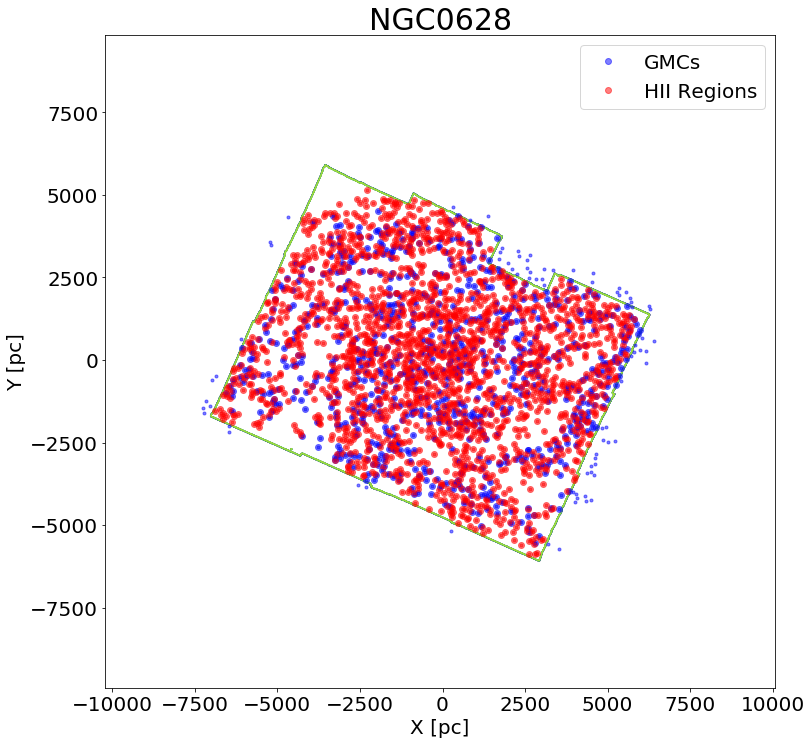

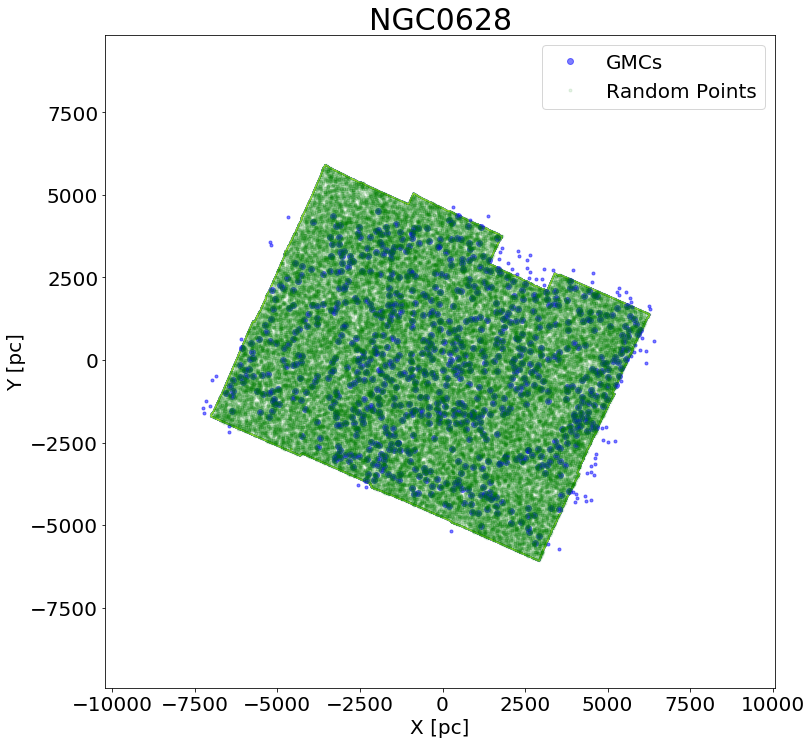

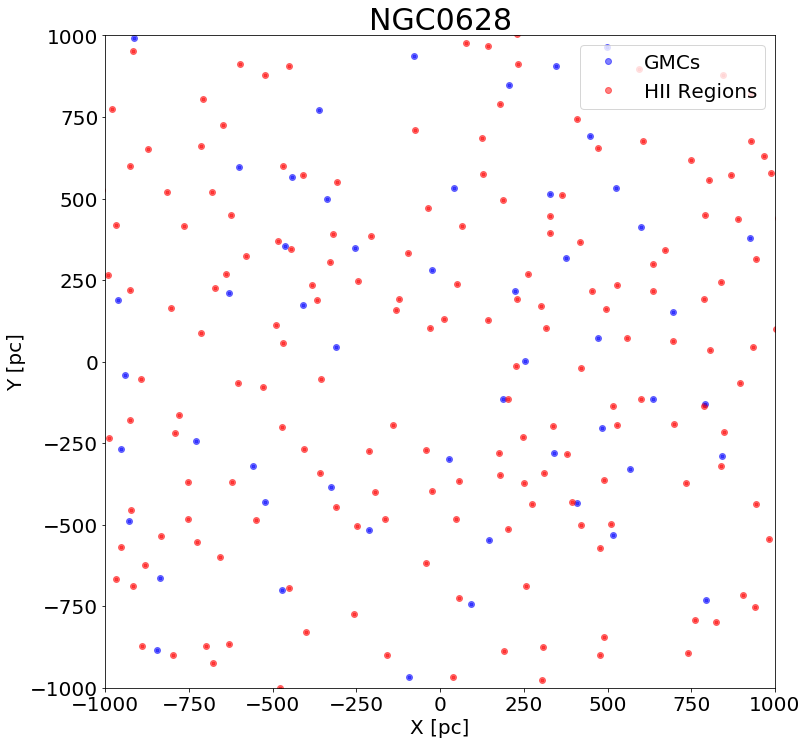

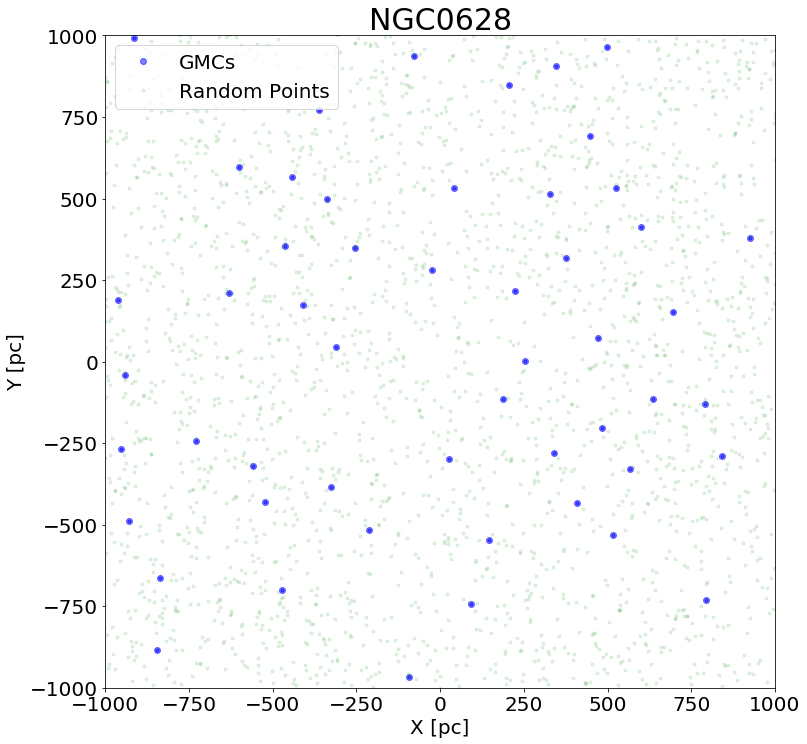

In [72]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(x1[sel1], y1[sel1], 'ob', alpha=0.5, label='GMCs')
ax.plot(x2[sel2], y2[sel2], 'or', alpha=0.5, label='HII Regions')
ax.plot(x1, y1, '.b', alpha=0.5)
ax.plot(x2, y2, '.r', alpha=0.5)
#ax.plot(xr, yr, '.g', alpha=0.1)
ax.set_xlim(np.min(xmask[mask]), np.max(xmask[mask]))
ax.set_ylim(np.min(ymask[mask]), np.max(ymask[mask]))
#ax.set_xlim(np.min(np.concatenate((x1[sel1], x2[sel2]))), np.max(np.concatenate((x1[sel1], x2[sel2]))))
#ax.set_ylim(np.min(np.concatenate((y1[sel1], y2[sel2]))), np.max(np.concatenate((y1[sel1], y2[sel2]))))
ax.contour(xmask, ymask, mask)
ax.set_aspect('equal', 'datalim')
ax.axis('equal')
plt.xlabel('X [pc]', fontsize=20)
plt.ylabel('Y [pc]', fontsize=20)
plt.title(galaxy, fontsize=30)
ax.tick_params(labelsize=20)
ax.legend(fontsize=20)
plt.savefig('./plots/'+galaxy+'_xy.png')
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(x1[sel1], y1[sel1], 'ob', alpha=0.5, label='GMCs')
#ax.plot(x2[sel2], y2[sel2], 'or', alpha=0.5)
ax.plot(x1, y1, '.b', alpha=0.5)
#ax.plot(x2, y2, '.r', alpha=0.5)
ax.plot(xr, yr, '.g', alpha=0.1, label='Random Points')
ax.set_xlim(np.min(xmask[mask]), np.max(xmask[mask]))
ax.set_ylim(np.min(ymask[mask]), np.max(ymask[mask]))
ax.contour(xmask, ymask, mask)
ax.set_aspect('equal', 'datalim')
ax.axis('equal')
plt.xlabel('X [pc]', fontsize=20)
plt.ylabel('Y [pc]', fontsize=20)
plt.title(galaxy, fontsize=30)
ax.tick_params(labelsize=20)
ax.legend(fontsize=20)
plt.savefig('./plots/'+galaxy+'_xy_rand.png')
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(x1[sel1], y1[sel1], 'ob', alpha=0.5, label='GMCs')
ax.plot(x2[sel2], y2[sel2], 'or', alpha=0.5, label='HII Regions')
ax.plot(x1, y1, '.b', alpha=0.5)
ax.plot(x2, y2, '.r', alpha=0.5)
#ax.plot(xr, yr, '.g', alpha=0.1)
ax.set_xlim(-1000, 1000)
ax.set_ylim(-1000, 1000)
ax.contour(xmask, ymask, mask)
plt.xlabel('X [pc]', fontsize=20)
plt.ylabel('Y [pc]', fontsize=20)
plt.title(galaxy, fontsize=30)
ax.tick_params(labelsize=20)
ax.legend(fontsize=20, loc=1)
plt.savefig('./plots/'+galaxy+'_xy.png')
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(x1[sel1], y1[sel1], 'ob', alpha=0.5, label='GMCs')
#ax.plot(x2[sel2], y2[sel2], 'or', alpha=0.5)
ax.plot(x1, y1, '.b', alpha=0.5)
#ax.plot(x2, y2, '.r', alpha=0.5)
ax.plot(xr, yr, '.g', alpha=0.1, label='Random Points')
ax.set_xlim(-1000, 1000)
ax.set_ylim(-1000, 1000)
ax.contour(xmask, ymask, mask)
plt.xlabel('X [pc]', fontsize=20)
plt.ylabel('Y [pc]', fontsize=20)
plt.title(galaxy, fontsize=30)
ax.tick_params(labelsize=20)
ax.legend(fontsize=20)
plt.savefig('./plots/'+galaxy+'_xy_rand.png')
plt.show()



## Calculate 2-point cross-correlation function between GMCs and HII regions

In [63]:
#Calculate correlation fucntion
r0, w0, ew0 = w(x1[sel1], y1[sel1], x2[sel2], y2[sel2], xr, yr)



ascii.write([r0, w0, ew0], './output/'+galaxy+'_corr.txt')
ascii.write([x1[sel1], y1[sel1]], './output/'+galaxy+'_xy_gmc.txt')
ascii.write([x2[sel2], y2[sel2]], './output/'+galaxy+'_xy_hii.txt')
ascii.write([xr, yr], './output/'+galaxy+'_xy_rand.txt')

# Write correlation function to disk

#xr, yr = rancat(xmask, ymask, mask, f=f, Nr=myNr)
#r1, w1 = w(x1, y1, x2, y2, xr, yr)
#
#xr, yr = rancat(xmask, ymask, mask, f=f, Nr=myNr)
#r2, w2 = w(x1, y1, x2, y2, xr, yr)
#
#xr, yr = rancat(xmask, ymask, mask, f=f, Nr=myNr)
#r3, w3 = w(x1, y1, x2, y2, xr, yr)



## Plot GMC - HII region 2-point cross-correlation function

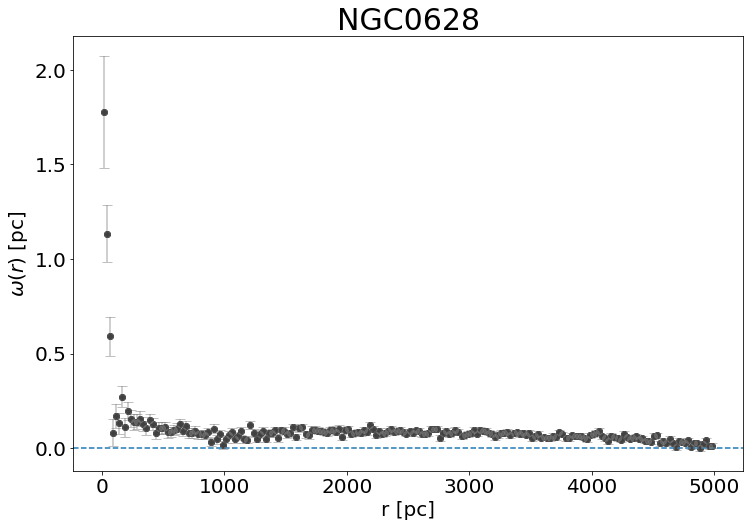

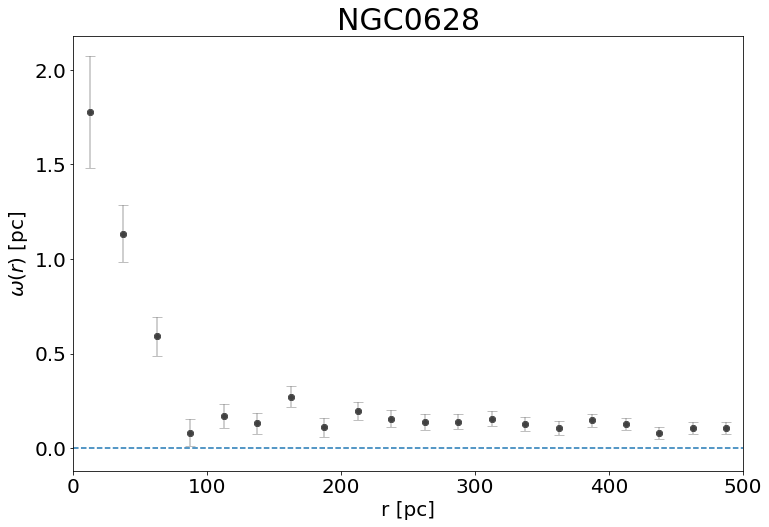

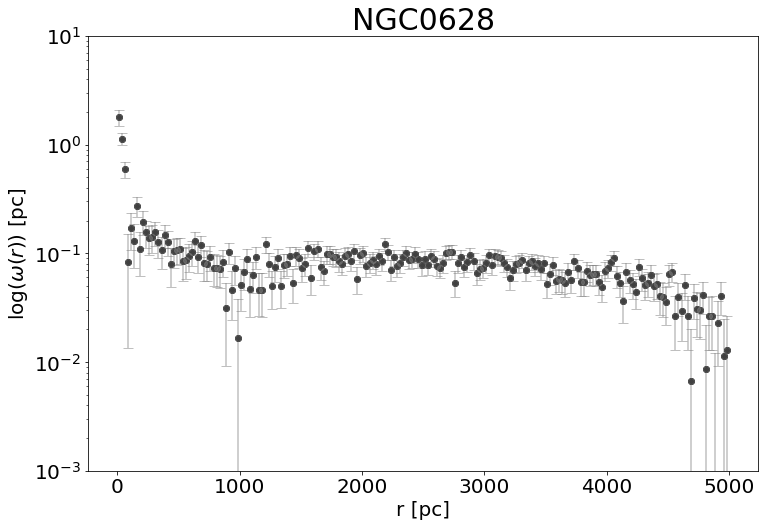

In [64]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(r0, w0, ew0, fmt="o", color='grey', capsize=5, alpha=0.5)
ax.plot(r0, w0, 'o', color='black', alpha=1.0)
#ax.plot(r1, w1, '-o')
#ax.plot(r2, w2, '-o')
#ax.plot(r3, w3, '-o')
#ax.set_xlim(0, 250)
ax.axhline(y=0, linestyle='--')
plt.xlabel('r [pc]', fontsize=20)
plt.ylabel(r'$\omega(r)$ [pc]', fontsize=20)
plt.title(galaxy, fontsize=30)
ax.tick_params(labelsize=20)
#ax.set_yscale('log')
plt.savefig('./plots/'+galaxy+'_corr.png')
plt.show()


fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(r0, w0, ew0, fmt="o", color='grey', capsize=5, alpha=0.5)
ax.plot(r0, w0, 'o', color='black', alpha=1.0)
#ax.plot(r1, w1, '-o')
#ax.plot(r2, w2, '-o')
#ax.plot(r3, w3, '-o')
ax.set_xlim(0, 500)
ax.axhline(y=0, linestyle='--')
plt.xlabel('r [pc]', fontsize=20)
plt.ylabel(r'$\omega(r)$ [pc]', fontsize=20)
plt.title(galaxy, fontsize=30)
ax.tick_params(labelsize=20)
#ax.set_yscale('log')
plt.savefig('./plots/'+galaxy+'_corr_zoom.png')
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(r0, w0, ew0, fmt="o", color='grey', capsize=5, alpha=0.5)
ax.plot(r0, w0, 'o', color='black', alpha=1.0)
#ax.plot(r1, w1, '-o')
#ax.plot(r2, w2, '-o')
#ax.plot(r3, w3, '-o')
#ax.set_xlim(0, 250)
ax.set_ylim(1e-3, 1e1)
ax.axhline(y=0, linestyle='--')
plt.xlabel('r [pc]', fontsize=20)
plt.ylabel(r'log($\omega(r)$) [pc]', fontsize=20)
plt.title(galaxy, fontsize=30)
ax.tick_params(labelsize=20)
ax.set_yscale('log')
plt.savefig('./plots/'+galaxy+'_corr_log.png')
plt.show()



1943
